In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib import ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import rcParams
from matplotlib import patches
import scipy.io
import astropy.constants as const
import juanfit
import copy
from scipy import interpolate
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.integrate import simps
from scipy.signal import find_peaks
rcParams['axes.linewidth'] = 1.5
import cmcrameri.cm as cmcm
import h5py
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval, ManualInterval

In [2]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [3]:
awsom_data_set = scipy.io.readsav(r'../../sav/AWSoM/streamer_test/box_var_8_n00080000.sav',verbose = True,python_dict=True)

--------------------------------------------------
Date: Fri Nov 11 12:04:51 2022
User: yjzhu
Host: 0587449807.wireless.umich.net
--------------------------------------------------
Format: 11
Architecture: x86_64
Operating System: darwin
IDL Version: 8.2
--------------------------------------------------
Successfully read 6 records of which:
 - 1 are of type VERSION
 - 3 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - x [<class 'numpy.ndarray'>]
 - w [<class 'numpy.ndarray'>]
 - param [<class 'numpy.ndarray'>]
--------------------------------------------------


In [4]:
m_p = const.m_p.cgs.value
k_b = const.k_B.cgs.value
c = const.c.cgs.value
rs = const.R_sun.cgs.value

In [5]:
p_e_ratio = 0.83
awsom_x = awsom_data_set['x'][0,0,0,:]
awsom_y = awsom_data_set['x'][1,0,:,0]
awsom_z = awsom_data_set['x'][2,:,0,0]
awsom_x_grid = awsom_data_set['x'][0,:,:,:]
awsom_y_grid = awsom_data_set['x'][1,:,:,:]
awsom_z_grid = awsom_data_set['x'][2,:,:,:]
rho = awsom_data_set['w'][0,:,:,:]
n = rho/m_p
#n = np.nan_to_num(n,nan=0)
ux = awsom_data_set['w'][1,:,:,:]
uy = awsom_data_set['w'][2,:,:,:]
uz = awsom_data_set['w'][3,:,:,:]
bx = awsom_data_set['w'][4,:,:,:]
by = awsom_data_set['w'][5,:,:,:]
bz = awsom_data_set['w'][6,:,:,:]
I01 = awsom_data_set['w'][8,:,:,:]
I02 = awsom_data_set['w'][9,:,:,:]
p = awsom_data_set['w'][11,:,:,:]
t = p/n/k_b
#t = np.nan_to_num(t,nan=1e3)
p_e = awsom_data_set['w'][10,:,:,:]
t_e = p_e/n/k_b
t_e = np.nan_to_num(t_e,nan=1e3)
n = np.nan_to_num(n,nan=1)
n = n + 1
b_tot = np.sqrt(np.square(bx) + np.square(by) + np.square(bz))
u_tot = np.sqrt(np.square(ux) + np.square(uy) + np.square(uz))
bx_rot = np.zeros_like(bx)
by_rot = np.zeros_like(by)
bz_rot = np.zeros_like(bz)
ux_rot = np.zeros_like(ux)
uy_rot = np.zeros_like(uy)
uz_rot = np.zeros_like(uz)

rot_DD = np.resize(awsom_data_set["param"],(3,3))
for ii in range(ux.shape[0]):
    for jj in range(ux.shape[1]):
        for kk in range(ux.shape[2]):
            bx_rot[ii,jj,kk],by_rot[ii,jj,kk],bz_rot[ii,jj,kk] = np.matmul([bx[ii,jj,kk],by[ii,jj,kk],bz[ii,jj,kk]],rot_DD.T)
            ux_rot[ii,jj,kk],uy_rot[ii,jj,kk],uz_rot[ii,jj,kk] = np.matmul([ux[ii,jj,kk],uy[ii,jj,kk],uz[ii,jj,kk]],rot_DD.T)

/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_46726/2558167840.py:20: RuntimeWarning: invalid value encountered in divide
  t = p/n/k_b
/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_46726/2558167840.py:23: RuntimeWarning: invalid value encountered in divide
  t_e = p_e/n/k_b


In [6]:
chianti_emiss_tbl = scipy.io.readsav("../../sav/AWSoM/chianti_table/FeXIV_FeX_emiss.sav",verbose=True,python_dict=True)

--------------------------------------------------
Date: Mon Oct 24 14:23:08 2022
User: yjzhu
Host: ptolemy.engin.umich.edu
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.7.2
--------------------------------------------------
Successfully read 8 records of which:
 - 1 are of type VERSION
 - 5 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - fexiv_emiss_array [<class 'numpy.ndarray'>]
 - fex_emiss_array [<class 'numpy.ndarray'>]
 - temp [<class 'numpy.ndarray'>]
 - dens [<class 'numpy.ndarray'>]
 - height [<class 'numpy.ndarray'>]
--------------------------------------------------


In [7]:
t_e.shape

(169, 96, 301)

In [17]:
awsom_z.shape

(169,)

In [9]:
height_grid = np.sqrt(awsom_x_grid**2 + awsom_y_grid**2 + awsom_z_grid**2)

In [10]:
FeXIV_emiss_func = interpolate.RegularGridInterpolator(points=(chianti_emiss_tbl["height"],chianti_emiss_tbl["dens"],chianti_emiss_tbl["temp"]),
                    values=chianti_emiss_tbl["fexiv_emiss_array"],
                    bounds_error=False,method="cubic")
FeXIV_emiss_box = FeXIV_emiss_func((height_grid[:,:,:], np.log10(n[:,:,:]), np.log10(t_e[:,:,:])))

In [11]:
FeXIV_emiss_box.shape

(169, 96, 301)

In [14]:
with h5py.File("../../sav/AWSoM/streamer_test/FeXIV_emiss_test.h5", 'w') as hf:
    df_FeXIV_emiss = hf.create_dataset("FeXIV_emiss",  data=FeXIV_emiss_box)

(<matplotlib.colorbar.Colorbar at 0x1b89bb640>, <AxesHostAxes: >)

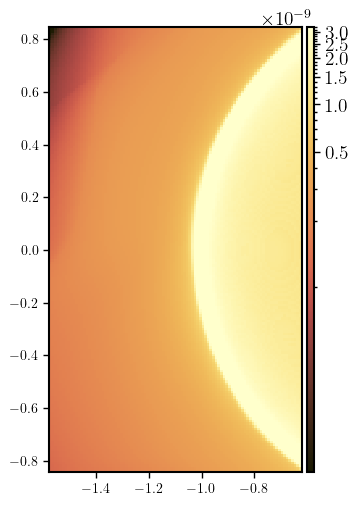

In [49]:
fig, ax = plt.subplots(figsize=(3,6),constrained_layout=True)
FeXIV_int = np.nansum(FeXIV_emiss_box,axis=2)
norm_FeXIV_int = ImageNormalize(FeXIV_int,interval=ZScaleInterval(),stretch=LogStretch())
im = ax.pcolormesh(awsom_y,awsom_z, FeXIV_int,norm=norm_FeXIV_int, cmap=cmcm.lajolla_r, shading="auto",rasterized=True)
ax.set_aspect(1)
plot_colorbar(im,ax)

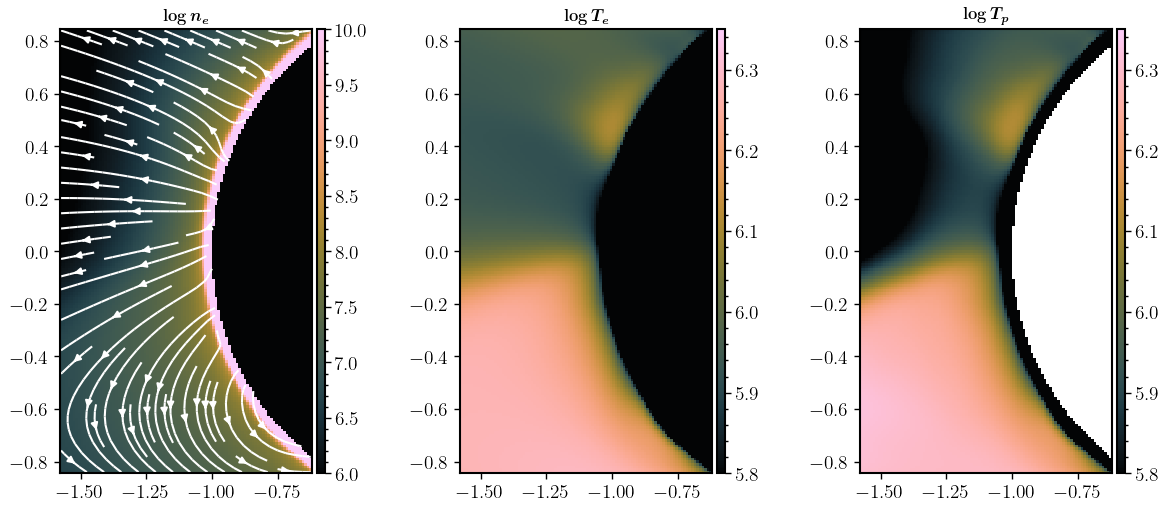

In [43]:
fig, axes = plt.subplots(1,3,figsize=(12,5),constrained_layout=True)
index_los = 150
im_n = axes[0].pcolormesh(awsom_y,awsom_z, np.log10(n[:,:,index_los]), cmap=cmcm.batlowK, 
                vmin=6,vmax=10,shading="auto",rasterized=True)
axes[0].set_title(r"$\boldsymbol{\log n_e}$")
plot_colorbar(im_n,axes[0])
axes[0].streamplot(awsom_y,awsom_z,by_rot[:,:,index_los],bz_rot[:,:,index_los],
color="white")

im_te = axes[1].pcolormesh(awsom_y,awsom_z, np.log10(t_e[:,:,index_los]), cmap=cmcm.batlowK, 
                vmin=5.8,vmax=6.35,shading="auto",rasterized=True)
plot_colorbar(im_te,axes[1])
axes[1].set_title(r"$\boldsymbol{\log T_e}$")
im_tp = axes[2].pcolormesh(awsom_y,awsom_z, np.log10(t[:,:,index_los]), cmap=cmcm.batlowK, 
                vmin=5.8,vmax=6.35,shading="auto",rasterized=True)
plot_colorbar(im_tp,axes[2])
axes[2].set_title(r"$\boldsymbol{\log T_p}$")
for ax_ in axes:
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)

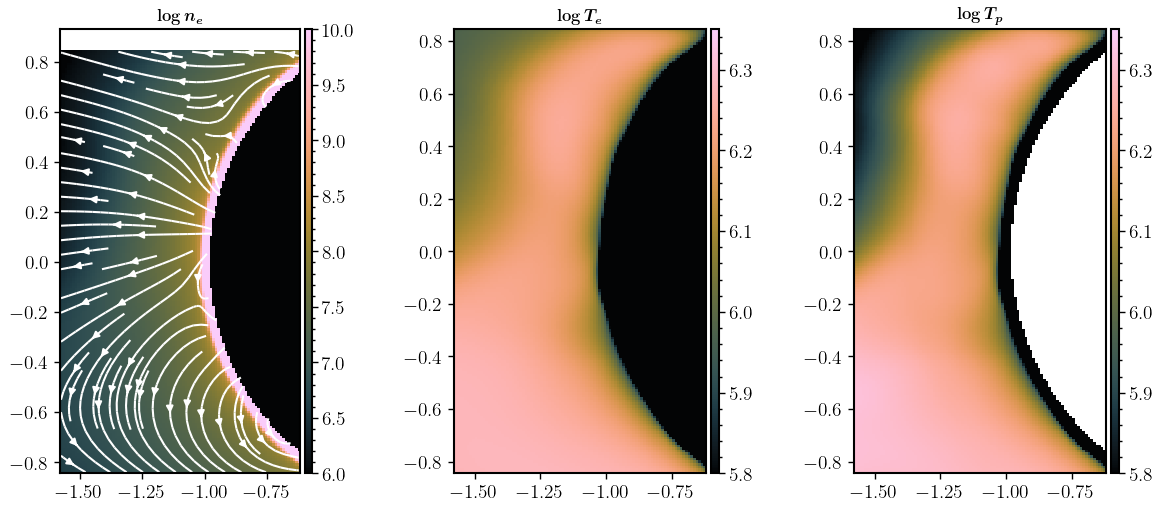

In [47]:
fig, axes = plt.subplots(1,3,figsize=(12,5),constrained_layout=True)
index_los = 170
im_n = axes[0].pcolormesh(awsom_y,awsom_z, np.log10(n[:,:,index_los]), cmap=cmcm.batlowK, 
                vmin=6,vmax=10,shading="auto",rasterized=True)
axes[0].set_title(r"$\boldsymbol{\log n_e}$")
plot_colorbar(im_n,axes[0])
axes[0].streamplot(awsom_y,awsom_z,by_rot[:,:,index_los],bz_rot[:,:,index_los],
color="white")

im_te = axes[1].pcolormesh(awsom_y,awsom_z, np.log10(t_e[:,:,index_los]), cmap=cmcm.batlowK, 
                vmin=5.8,vmax=6.35,shading="auto",rasterized=True)
plot_colorbar(im_te,axes[1])
axes[1].set_title(r"$\boldsymbol{\log T_e}$")
im_tp = axes[2].pcolormesh(awsom_y,awsom_z, np.log10(t[:,:,index_los]), cmap=cmcm.batlowK, 
                vmin=5.8,vmax=6.35,shading="auto",rasterized=True)
plot_colorbar(im_tp,axes[2])
axes[2].set_title(r"$\boldsymbol{\log T_p}$")
for ax_ in axes:
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)